<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Catboost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

Инструкция по выполнению проекта:
- Загрузите данные и выполните их ресемплирование по одному часу.
- Проанализируйте данные.
- Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
- Проверьте данные на тестовой выборке и сделайте выводы.

Описание данных:
Данные лежат в файле /datasets/taxi.csv. Скачать датасет.
Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [2]:
df_taxi = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=[0])

In [3]:
df_taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


В датасете 2 столбца:
1. Дата
2. Количество заказов

In [4]:
df_taxi.sort_index(inplace=True)
df_taxi.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


## Анализ

In [6]:
# проводим ресемплирование датасета по 1 часу
df_taxi = df_taxi.resample('1H').sum()

In [7]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Количество строк уменьшилось в 6 раз тк. до этого выгрука была за каждые 10 минут

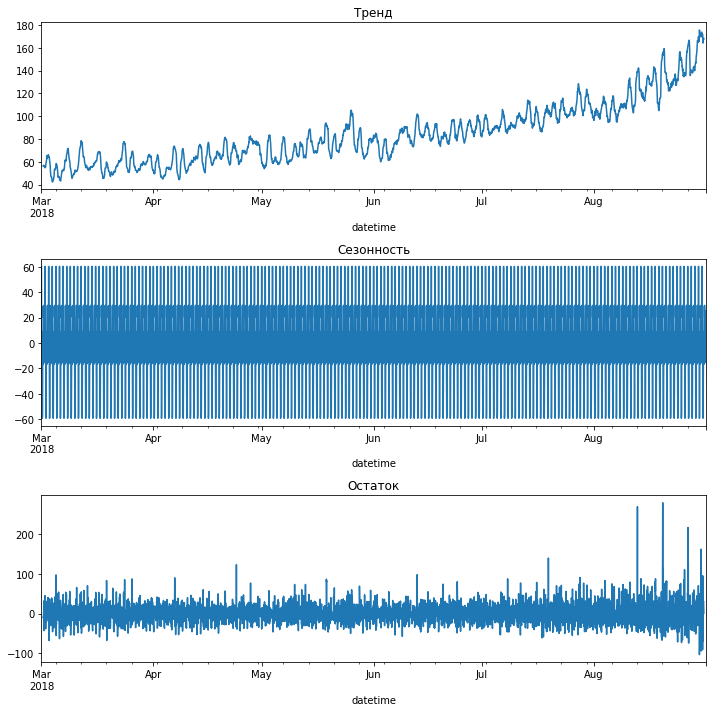

In [8]:
# Посмотрим тренды и сезонность
decomposed = seasonal_decompose(df_taxi)

plt.figure(figsize=(10, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

По тренду видно постоянное увеличение количества заказаов, по сезонности не понятно. возьмем отрезок в последний месяц.

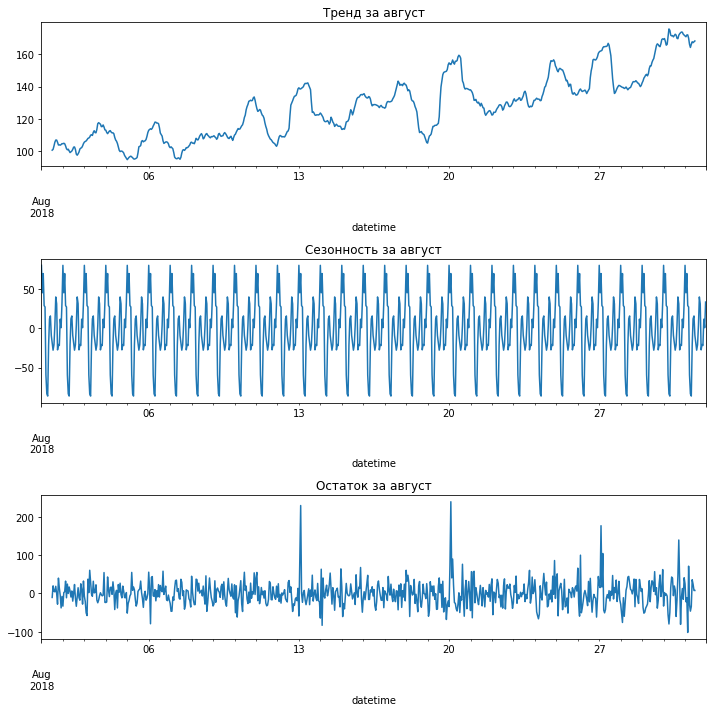

In [9]:
decomposed_aug = seasonal_decompose(df_taxi['2018-08-01':'2018-08-31'])

plt.figure(figsize=(10, 10))

plt.subplot(311)
decomposed_aug.trend.plot(ax=plt.gca())
plt.title('Тренд за август')

plt.subplot(312)
decomposed_aug.seasonal.plot(ax=plt.gca())
plt.title('Сезонность за август')

plt.subplot(313)
decomposed_aug.resid.plot(ax=plt.gca())
plt.title('Остаток за август')
plt.tight_layout()

В сезонности так же показывает стабильность. Возьмем отрезок в 1 день

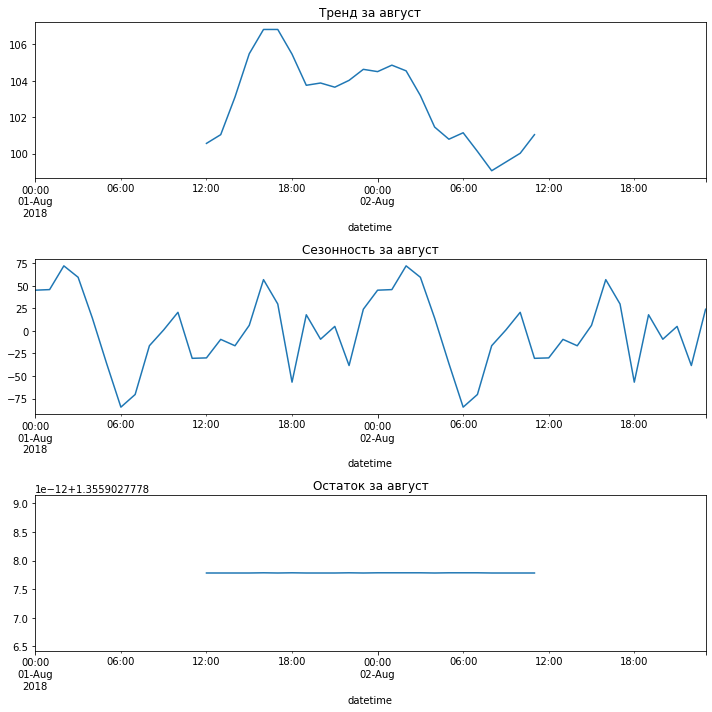

In [10]:
decomposed_aug = seasonal_decompose(df_taxi['2018-08-01':'2018-08-02'])

plt.figure(figsize=(10, 10))

plt.subplot(311)
decomposed_aug.trend.plot(ax=plt.gca())
plt.title('Тренд за август')

plt.subplot(312)
decomposed_aug.seasonal.plot(ax=plt.gca())
plt.title('Сезонность за август')

plt.subplot(313)
decomposed_aug.resid.plot(ax=plt.gca())
plt.title('Остаток за август')
plt.tight_layout()

Видно что пик заказов приходится на 1 ночи, до 6 утра идет спад, далее резкоое падение с 11-12 часов, затем снова рост до 16 часов, и далее рост с 18 до 2 ночи. 

## Обучение

In [11]:
# создаем функцию подсчета RMSE
def rmse(target, prediction):
    return mean_squared_error(target, prediction)**0.5

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy(deep=True)
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df

#возьмем произвольные значения
df_taxi = make_features(df_taxi, 30, 40)

In [13]:
df_taxi.sample(5)

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-21 06:00:00,64,8,21,1,48.0,216.0,219.0,142.0,239.0,173.0,...,94.0,44.0,47.0,118.0,273.0,224.0,462.0,272.0,200.0,154.600
2018-07-24 14:00:00,116,7,24,1,64.0,93.0,88.0,94.0,114.0,68.0,...,127.0,118.0,86.0,93.0,118.0,136.0,94.0,152.0,88.0,108.725
2018-07-18 03:00:00,120,7,18,2,130.0,54.0,159.0,101.0,56.0,82.0,...,84.0,104.0,99.0,102.0,123.0,131.0,102.0,85.0,111.0,91.175
2018-05-25 02:00:00,171,5,25,4,80.0,117.0,107.0,105.0,149.0,143.0,...,96.0,128.0,146.0,98.0,125.0,144.0,118.0,123.0,83.0,92.200
2018-08-23 18:00:00,160,8,23,3,187.0,180.0,122.0,112.0,88.0,143.0,...,130.0,121.0,116.0,184.0,174.0,92.0,145.0,119.0,69.0,127.700


In [14]:
# Проверяем RMSE на двух константных моделях: прогноз медианы и прогноз предыдущего значения ряда.
train, test = train_test_split(df_taxi, shuffle=False, test_size=0.1)
train = train.dropna()

#константная модель, прогнозирующая медиану
pred_median = np.ones(test.shape) * train['num_orders'].median()
rmse_median = mean_squared_error(test, pred_median)**0.5
print("RMSE константной модели, прогнозирующей медиану:", rmse_median)

#константная модель, прогнозирующая предыдущее значение ряда
pred_previous = pd.Series(train['num_orders'].iloc[-len(test):])
print("RMSE константной модели, прогнозирующей предыдущее значение ряда:",
      rmse(test['num_orders'], pred_previous))

RMSE константной модели, прогнозирующей медиану: 84.54772153207533
RMSE константной модели, прогнозирующей предыдущее значение ряда: 81.82849573915023


In [15]:
#подготавливаю обучающую и тестовую выборки
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']
print('Размер обучающей выборки:', features_train.shape)
print('Размер тестовой выборки:', features_test.shape)

Размер обучающей выборки: (3934, 34)
Размер тестовой выборки: (442, 34)


### Линейная регрессия

In [16]:
linear_model = LinearRegression()
linear_model.fit(features_train, target_train)
 
linear_prediction = linear_model.predict(features_train)
print('RMSE линейной регрессии составляет:', rmse(target_train, linear_prediction))

RMSE линейной регрессии составляет: 25.162063268252812


### Случайный лес

In [28]:
forest_model = RandomForestRegressor(random_state=12345)
forest_params = {'n_estimators':range(10, 50, 10), 'max_depth':range(10, 20)}
tscv = TimeSeriesSplit(n_splits=5)
forest_grid = GridSearchCV(forest_model, forest_params, scoring = 'neg_root_mean_squared_error', cv=tscv, n_jobs=-1)
forest_grid.fit(features_train, target_train)
forest_prediction = forest_grid.predict(features_train)

print('Лучшие параметры случайного леса:', forest_grid.best_params_)
print('RMSE случайного леса составляет:', rmse(target_train, forest_prediction))

Лучшие параметры случайного леса: {'max_depth': 17, 'n_estimators': 40}
RMSE случайного леса составляет: 9.437120311120644


По результатам самый оптимальный параметр tscv = 5, благодаря этому RMSE  стало 9.43

### Catboost

In [18]:
cat_model = CatBoostRegressor(iterations=100, verbose=False, random_state=12345)
cat_params = {'learning_rate':[0.1, 0.2], #скорость обучения
              'depth':[10, 15, 20]} #depth - глубина дерева
cat_grid = GridSearchCV(cat_model, cat_params, scoring = 'neg_root_mean_squared_error', n_jobs=-1)
cat_grid.fit(features_train, target_train)
cat_prediction = cat_grid.predict(features_train)

print('Лучшие параметры Catboost:', cat_grid.best_params_)
print('RMSE Catboost составляет:', rmse(target_train, cat_prediction))

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 5839, in _catboost._check_train_params
  File "_catboost.pyx", line 5858, in _catboost._check_train

Лучшие параметры Catboost: {'depth': 10, 'learning_rate': 0.2}
RMSE Catboost составляет: 8.727089751159276


### LightGBM

In [19]:
gbm_model = LGBMRegressor(random_state=12345)
gbm_params = {'n_estimators':[100, 150], #количество деревьев решений
              'num_leaves':[10, 15, 20]} #количество терминальных узлов (листьев) дерева
gbm_grid = GridSearchCV(gbm_model, gbm_params, scoring = 'neg_root_mean_squared_error', n_jobs=-1)
gbm_grid.fit(features_train, target_train)
gbm_prediction = gbm_grid.predict(features_train)

print('Лучшие параметры LightGBM OE:', gbm_grid.best_params_)
print('RMSE LightGBM составляет:', rmse(target_train, gbm_prediction))

Лучшие параметры LightGBM OE: {'n_estimators': 150, 'num_leaves': 20}
RMSE LightGBM составляет: 12.646130546023427


Вывод:
1. Все четыре модели продемонстрировали результат RMSE меньше 48.
2. Самый лучший результаит у случайного леса и catboost. 

## Тестирование

In [29]:
#Создаем сравнительную таблицу
data={'Модель': ['Linear Regression', 'RandomForest', 'CatBoost', 'LightGBM', 'Constant Median', 'Constant Previous'],
      'RMSE': [25.16, 9.43, 8.72, 12.64, 84.54, 81.82]}
data_pivot=pd.DataFrame.from_dict(data)
display(data_pivot)

,Модель,RMSE
0,Linear Regression,25.16
1,RandomForest,9.43
2,CatBoost,8.72
3,LightGBM,12.64
4,Constant Median,84.54
5,Constant Previous,81.82


In [21]:
# Проверяем rmse случайного леса и catboost на тесмтовой выборке
forest = RandomForestRegressor(random_state=12345, max_depth=17, n_estimators=40)
forest.fit(features_train, target_train)
forest_pred = forest.predict(features_test)
print('RMSE случайного леса на тестовой выборке составляет:', rmse(target_test, forest_pred))

RMSE случайного леса на тестовой выборке составляет: 43.78905280006859


In [22]:
catboost = CatBoostRegressor(iterations=100, verbose=False, random_state=12345,
                            learning_rate=0.1, depth=10)
catboost.fit(features_train, target_train)
catboost_pred = catboost.predict(features_test)
print('RMSE Catboost на тестовой выборке составляет:', rmse(target_test, catboost_pred))

RMSE Catboost на тестовой выборке составляет: 46.54525607876236


На тестовой ваыборке RMSE хуже чем на обучающей, однако в порог 48 уложились. Лучший результат у случайного леса с результьатом 43.78.

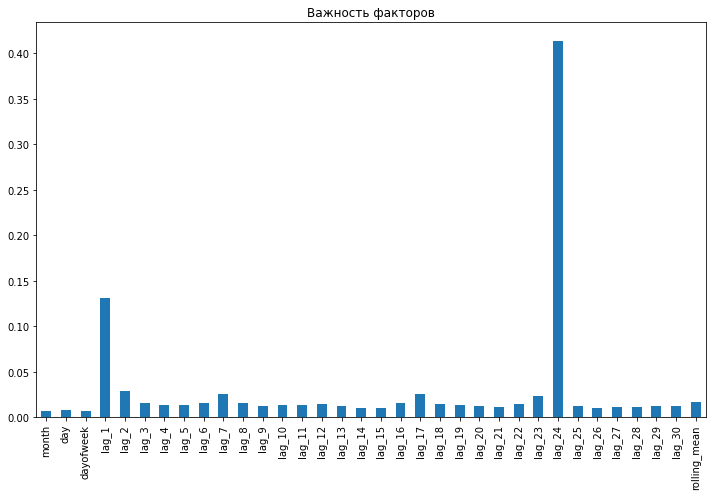

In [23]:
# Смотрим график важности факторов
feature_names = features_train.columns 
model = RandomForestRegressor(n_estimators=40, max_depth=18, random_state=12345)
model.fit(features_train, target_train)
pred = model.predict(features_test)
importances = model.feature_importances_
model_importances = pd.Series(importances, index=feature_names)

std = np.std([model.feature_importances_ for tree in str(1000)], axis=0)

fig, ax = plt.subplots(figsize=(10,7))
model_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Важность факторов")
fig.tight_layout()

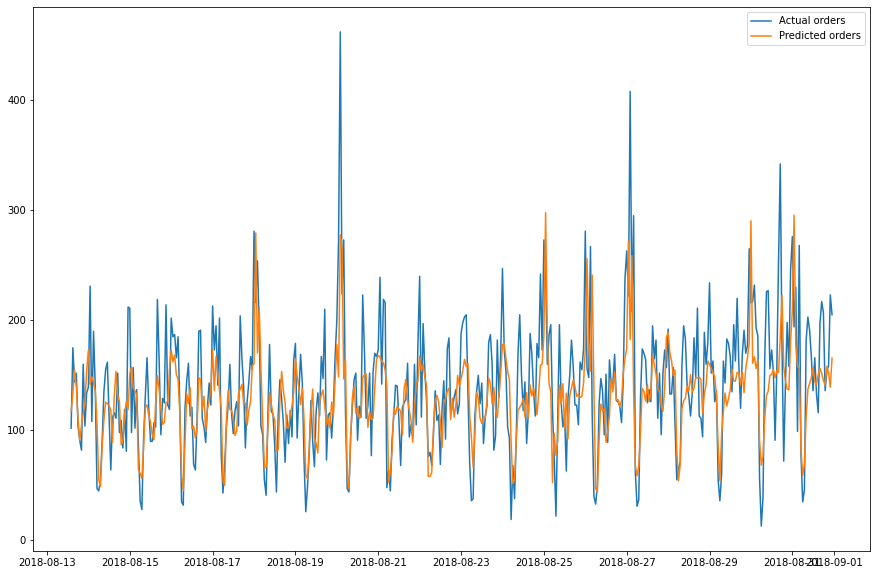

In [24]:
# Смогтрим соотрношение предсказаний модели с актуальнымиданными из выгрузки по заказам
plt.figure(figsize=(15, 10))
plt.plot(features_test.index, target_test, label='Actual orders')
plt.plot(features_test.index, forest_pred, label='Predicted orders')
plt.legend()
plt.show()

На графике видно что модель работает адекватно за исключением редких выбросов

### Вывод:
1. В датасете 2 столбца:
- Дата
- Количество заказов
2. В датасете данные с 00:00 1.03.2018 по 23:50 31.08.2018
3. было проведено ресемплировани датасета по 1 часу, по тренду видно постоянное увеличение заказыов, по сезонности видно что пик с 00:00 по 02:00.
4. При подготовке датасета к работе с моделями были созданы доп признаки: месяц, день, день недели, отстающие значения, скользящее среднее. Создана константная модель. Подготовлены обучающая и тестовая выборки в соотношении9к1
5. RMSE константной модели, прогнозирующий медиану составил 84ю54, прогнозирующей предыдкщее значение ряда составил 81,82
6. Были обучены 4 модели:
    1. линейная регресситя с RMSE 25.16
    2. случайный лес с RMSE 9.43
    3. catboost с RMSE 8.72
    4. lightGBM c RMSE 12.64
7. Для проверки на тестовой выборке были выбраны случайный лес, показавший RMSE и catboost c RMSE
8. Обе модели преодалили порог в 48.